In [1]:
from __future__ import division
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn

np.random.seed(12345)

class KalmanFilter(object):
    # Problem 1
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
     
    # Problem 3
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the 
        Kalman system.
        
        Parameters
        ----------
        x0 : ndarray of shape (n,)
             The initial state.
        N : integer
            The number of time steps to evolve.
        
        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        
        """
        
        states = [x0]
        obs = [x0[:2] + np.random.multivariate_normal([0,0], 5000*np.eye(2))]
        
        current_state = x0
        
        for i in xrange(N-1):
            s = self.F.dot(current_state) + np.eye(4).dot(self.u)
            
            delta = np.random.multivariate_normal([0,0], 5000*np.eye(2))
            o = s[:2] + delta
            
            states.append(s)
            obs.append(o)
            
            current_state = s.copy()
            
        return np.array(states).T, np.array(obs).T
    
    # Problem 4
    def estimate(self,x0,P,z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.
        
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).
        
        Returns
        -------
        out : ndarray of shape (n,N)
              Sequence of state estimates (each column is an estimate).
        """
        
        x = x0.copy()
        F = self.F
        Q = self.Q
        H = self.H
        R = self.R
        u = self.u
        
        states = [x]
        for i in xrange(z.shape[1]):
            # Predict step
            x_ = F.dot(x) + u
            P_ = F.dot(P).dot(F.T) + Q

            # Update step
            y = z[:,i] - H.dot(x_)
            S = H.dot(P_).dot(H.T) + R
            K = P_.dot(H.T).dot(la.inv(S))
            x = x_ + K.dot(y)
            P = (np.eye(Q.shape[0]) - K.dot(H)).dot(P_)
            
            # store prediction
            states.append(x_)
        
        return np.array(states).T
    
    # Problem 6
    def predict(self,x0,k):
        """
        Predict the next k states in the absence of observations.
        
        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
              The next k predicted states.
        """
        pred = [x0]
        
        x = x0.copy()
        for i in xrange(k):
            x = self.F.dot(x) + self.u
            pred.append(x)
        
        return np.array(pred).T
    
    # Problem 8
    def rewind(self,x0,k):
        """
        Predict the k states preceding the current state estimate x.
        
        Parameters
        ----------
        x0 : ndarray of shape (n,)
             The current state estimate.
        k : integer
             The number of preceding states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
              The k preceding predicted states.
        """
        rew = [x0]
        
        x = x0.copy()
        Finv = la.inv(self.F)
        for i in xrange(k):
            x = Finv.dot(x - self.u)
            rew.append(x)
        
        return np.array(rew).T
            

### Problem 2  

In [2]:
F = np.array([[1, 0, 0.1,  0 ],
            [0, 1,  0 , 0.1],
            [0, 0,  1 ,  0 ],
            [0, 0,  0 ,  1 ]])
Q = 0.1*np.eye(4)
H = np.array([[1,0,0,0],[0,1,0,0]])
R = 5000*np.eye(2)
u = np.array([0,0,0,-0.98])

kf = KalmanFilter(F,Q,H,R,u)

### Problem 3

In [3]:
x0 = np.array([0,0,300,600])
states, obs = kf.evolve(x0, 1250)

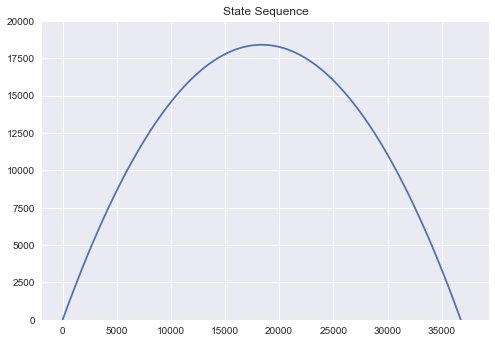

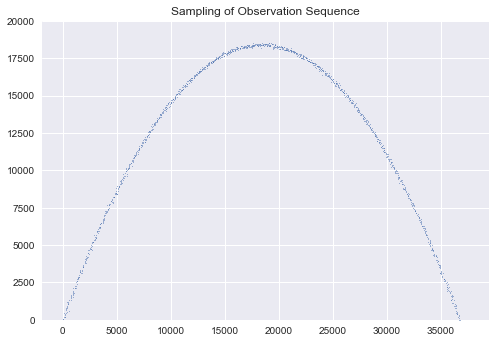

In [4]:
plt.plot(states[0], states[1])
plt.title("State Sequence")
plt.ylim([0,20000])
plt.show()

plt.scatter(obs[0], obs[1], s=.2)
plt.title("Sampling of Observation Sequence")
plt.ylim([0,20000])
plt.show()

### Problem 5

In [5]:
Vx = np.diff(obs[0,200:209]).mean() / 0.1
Vy = np.diff(obs[1,200:209]).mean() / 0.1

x0 = np.array([obs[0,200], obs[1,200], Vx, Vy])
P = 10**6*Q

estimates = kf.estimate(x0, P, obs[:,201:800])

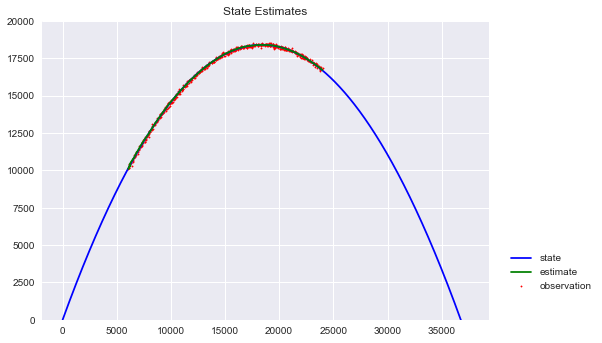

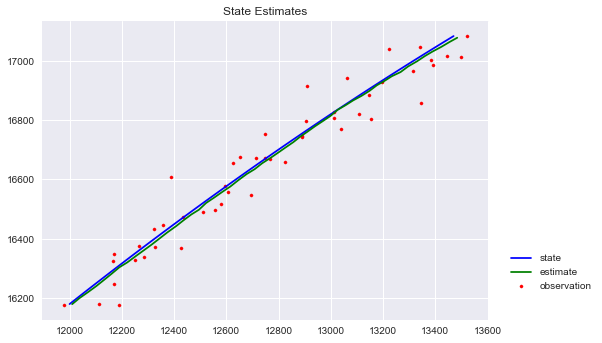

In [6]:
plt.plot(states[0], states[1], 'b', label='state')
plt.scatter(obs[0,201:800], obs[1,201:800], c='red', s=2, label='observation')
plt.plot(estimates[0], estimates[1], 'g', label='estimate')
plt.legend(bbox_to_anchor=(1.25,.25))
plt.title("State Estimates")
plt.ylim([0,20000])
plt.show()

plt.plot(states[0,400:450], states[1,400:450], 'b', label='state')
plt.scatter(obs[0,401:450], obs[1, 401:450], c='red', s=10, label='observation')
plt.plot(estimates[0,200:250], estimates[1,200:250], 'g', label='estimate')
plt.legend(bbox_to_anchor=(1.25,.25))
plt.title("State Estimates")
plt.show()

### Problem 7 

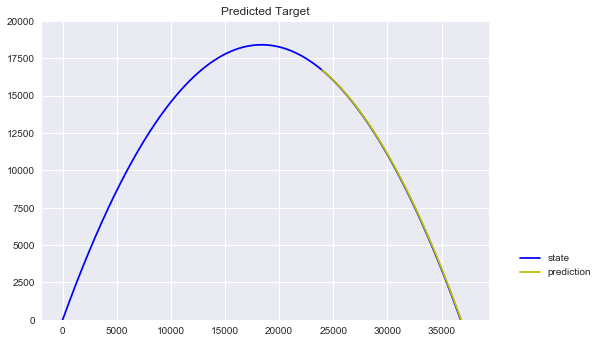

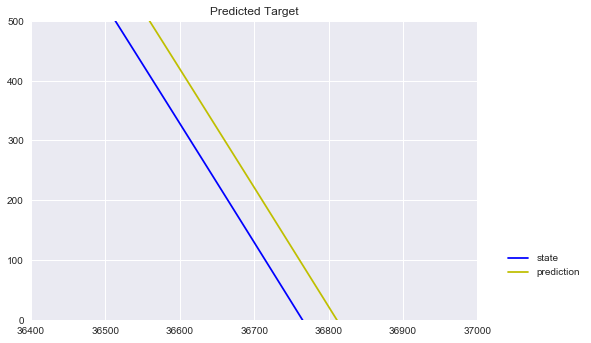

In [7]:
predictions = kf.predict(estimates[:,-1], 450)
plt.plot(states[0], states[1], 'b', label="state")
plt.plot(predictions[0], predictions[1], 'y', label="prediction")
plt.ylim([0,20000])
plt.title("Predicted Target")
plt.legend(bbox_to_anchor=(1.25,.25))

plt.show()

plt.plot(states[0], states[1], 'b', label="state")
plt.plot(predictions[0], predictions[1], 'y', label="prediction")
plt.ylim([0,500])
plt.xlim([36400,37000])
plt.title("Predicted Target")
plt.legend(bbox_to_anchor=(1.25,.25))

plt.show()

### Problem 9

In [8]:
x250 = estimates[:,50]
x600 = estimates[:,400]
rewind250 = kf.rewind(x250, 300)
rewind600 = kf.rewind(x600, 700)

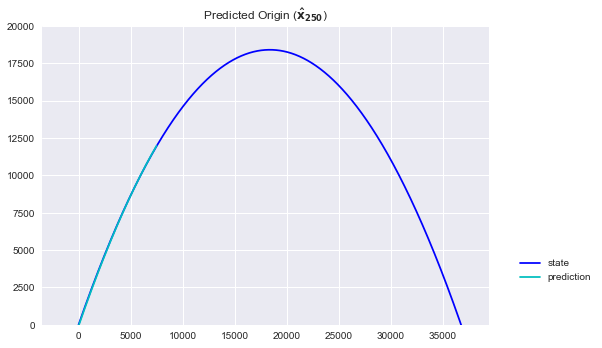

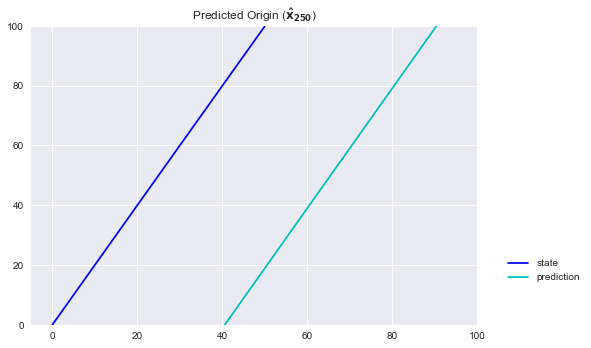

In [9]:
plt.plot(states[0], states[1], 'b', label="state")
plt.plot(rewind250[0], rewind250[1], 'c', label="prediction")
plt.ylim([0,20000])
plt.legend(bbox_to_anchor=(1.25,.25))
plt.title(r"Predicted Origin ($\bf{\hat{x}}_{250}$)")
plt.show()

plt.plot(states[0], states[1], 'b', label="state")
plt.plot(rewind250[0], rewind250[1], 'c', label="prediction")
plt.ylim([0,100])
plt.xlim([-5,100])
plt.legend(bbox_to_anchor=(1.25,.25))
plt.title(r"Predicted Origin ($\bf{\hat{x}}_{250}$)")
plt.show()

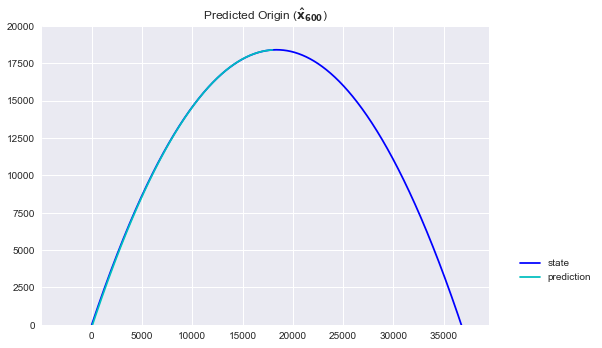

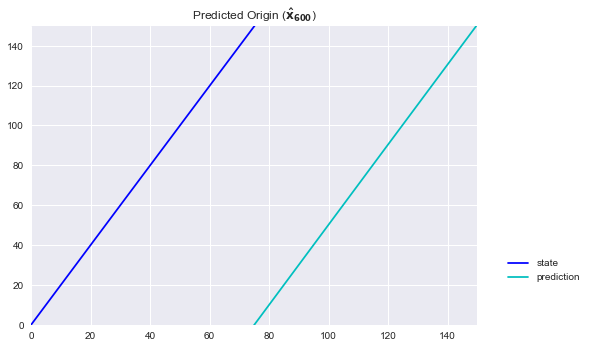

In [15]:
plt.plot(states[0], states[1], 'b', label='state')
plt.plot(rewind600[0], rewind600[1], 'c', label='prediction')
plt.ylim([0,20000])
plt.legend(bbox_to_anchor=(1.25,.25))
plt.title(r"Predicted Origin ($\bf{\hat{x}}_{600}$)")
plt.show()

plt.plot(states[0], states[1], 'b', label='state')
plt.plot(rewind600[0], rewind600[1], 'c', label='prediction')
plt.ylim([0,150])
plt.xlim([0,150])
plt.legend(bbox_to_anchor=(1.25,.25))
plt.title(r"Predicted Origin ($\bf{\hat{x}}_{600}$)")
plt.show()

The prediction using $\bf{\hat{x}}_{250}$ was much better than the prediction using $\bf{\hat{x}}_{600}$ because the small errors in our predictions didn't have enough iterations to accumulate. However, being off by < 80 meters is still quite respectable.